In [1]:
%load_ext autoreload
%autoreload 2


%matplotlib inline
%cd C:\MAD4AG

from tqdm.auto import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
import geopandas as gpd
import shapely
from shapely.geometry import LineString, Point


warnings.filterwarnings('ignore')

C:\MAD4AG


C:\Users\aglar\AppData\Local\anaconda3\envs\pycharm\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [19]:
day ='2'

file = r'.\dbs\twins\03-21-schedule-%s.pkl'%day

df_act_schedule_0 = pd.read_pickle(file)



In [20]:
# # pick an agent by the sequence

individual_uid= df_act_schedule_0['uid'][df_act_schedule_0['act_seq_simp_'+day]==('Home', 'Other','Work','Other','Other','Other', 'Home')].iloc[28]

individual = df_act_schedule_0[(df_act_schedule_0['uid']==individual_uid)]



In [4]:
individual['dur'] = individual['h_e']- individual['h_s']
individual['dur'] = individual['dur'] / 60
individual['dur'] = individual['dur'].round(2)

individual['h_s'] = individual['h_s']/60
individual['h_s'] = individual['h_s'].round(1)


In [5]:
sch_color_dict = {
    'Home': 'tab:green',
    'Work': 'tab:blue',
    'Other': 'tab:orange'
}

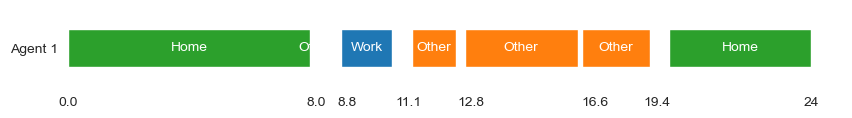

In [6]:
# # Declaring a figure "gnt"
fig, ax = plt.subplots(figsize=(10, 1))

# Setting Y-axis limits
ax.set_xlim(0, 25)
ax.set_ylim(-2, 2)
#sns.scatterplot(df_tst, y='PId', x='time', ax=ax)
ax.broken_barh(list(zip(individual.h_s, individual.dur)), (-1, 2),
               facecolors =[sch_color_dict[x] for x in individual.purpose])
for x1, x2, act in individual[['h_s', 'dur', 'purpose']].values:
    ax.text(x=x1 + x2/2,
            y=0,
            s=act,
            ha='center',
            va='center',
            color='white',
            )
ax.set_xticks([np.round(x) for x in individual.h_s] + [24],
              labels=[x for x in individual.h_s] + [24])
ax.set_yticks([0], labels=[f'Agent {1}'])
plt.box(on=None)
plt.show()

In [49]:
individual_trip = individual.copy()
individual_trip['lat_dest'] =individual_trip['lat'].shift(1)
individual_trip['lng_dest'] =individual_trip['lng'].shift(1)
individual_trip = individual_trip.iloc[1:]


In [50]:

individual_trip['from'] = individual_trip.apply(lambda row: Point([row['lat'], row['lng']]), axis=1)
individual_trip['to'] = individual_trip.apply(lambda row: Point([row['lat_dest'], row['lng_dest']]), axis=1)

individual_trip['geometry'] = individual_trip.apply(lambda row: LineString([row['from'], row['to']]), axis=1) #Create a linestring column

individual_trip['points'] = individual_trip.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

In [51]:
color_dict = {
'Home': 'green',
'Work': 'blue',
'Other': 'orange'}

icon_dict = {
'Home': 'home',
'Work': 'briefcase',
'Other': 'shopping-cart'}

In [52]:
m = folium.Map(location=[np.mean(individual['lat']),np.mean(individual['lng'])], zoom_start=9)

fg = folium.FeatureGroup(name="Day 1", show=True).add_to(m)


individual.apply(lambda row : folium.CircleMarker(
    location=(row["lat"], row["lng"]), radius=5,
    fill_color=color_dict[row['purpose']],
    popup=row['purpose'],
    color=color_dict[row['purpose']],
    fill_opacity=0.4,opacity=0.6).add_to(fg), axis=1)

individual_trip.apply(lambda row : folium.PolyLine(locations=row["points"],
                                                  color='gray',
                                                  opacity=0.8,
                                                  popup = 'trip '+str(row['act_seq'])
                                                  ).add_to(fg ), axis=1)

individual_trip.apply(lambda row : folium.Marker(
    location=(row['geometry'].centroid.x+0.003,row['geometry'].centroid.y+0.003),
    icon=folium.DivIcon(html=f"""<div style="font-family: Arial; font-size: 12px;">trip_{str(row['act_seq'])}</div>"""),
    opacity=0.8).add_to(fg ), axis=1)

individual.apply(lambda row : folium.Marker(
    location=(row["lat"], row["lng"]),
    icon=folium.Icon( icon=icon_dict[row['purpose']], color=color_dict[str(row['purpose'])], prefix='fa'),
    popup=row['purpose'],
    opacity=0.8).add_to(fg ), axis=1)

# folium.map.CustomPane("labels").add_to(m)
folium.LayerControl().add_to(m)




m

## multiple day visualization

In [3]:
def plot_activity_plan(individual=None, day='0'):
    individual['dur'] = individual['h_e'] - individual['h_s']
    individual['dur'] = individual['dur'] / 60
    individual['dur'] = individual['dur'].round(2)
    individual['h_s'] = individual['h_s'] / 60
    individual['h_s'] = individual['h_s'].round(1)

    sch_color_dict = {
        'Home': 'tab:green',
        'Work': 'tab:blue',
        'Other': 'tab:orange'
    }


    # Setting Y-axis limits
    ax.set_xlim(0, 25)
    ax.set_ylim(-2, 2)
    #sns.scatterplot(df_tst, y='PId', x='time', ax=ax)
    ax.broken_barh(list(zip(individual.h_s, individual.dur)), (-1, 2),
                   facecolors=[sch_color_dict[x] for x in individual.purpose])
    for x1, x2, act in individual[['h_s', 'dur', 'purpose']].values:
        ax.text(x=x1 + x2 / 2,
                y=0,
                s=act,
                ha='center',
                va='center',
                color='white',
                )
    ax.set_xticks([np.round(x) for x in individual.h_s] + [24],
                  labels=[x for x in individual.h_s] + [24])
    ax.set_yticks([0], labels=['Day '+str(int(day)+1)])
    ax.set_facecolor('white')
    ax.grid(False)
    # plt.box(on=None)
    # #plt.show()

In [4]:
def trip_generator(individual=None, day='0'):

    individual_trip = individual.copy()
    individual_trip['lat_dest'] = individual_trip['lat'].shift(1)
    individual_trip['lng_dest'] = individual_trip['lng'].shift(1)
    individual_trip = individual_trip.iloc[1:]
    individual_trip['from'] = individual_trip.apply(lambda row: Point([row['lat'], row['lng']]), axis=1)
    individual_trip['to'] = individual_trip.apply(lambda row: Point([row['lat_dest'], row['lng_dest']]), axis=1)
    individual_trip['geometry'] = individual_trip.apply(lambda row: LineString([row['from'], row['to']]),axis=1)  #Create a linestring column
    individual_trip['points'] = individual_trip.apply(lambda x: [y for y in x['geometry'].coords], axis=1)



    return pd.DataFrame(individual_trip)

<Figure size 1000x800 with 0 Axes>

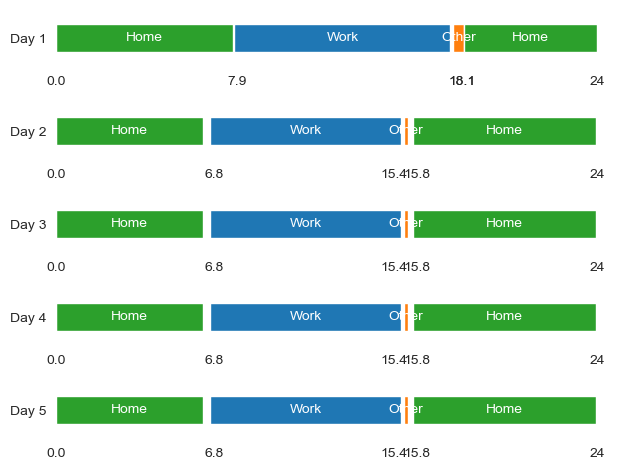

In [6]:
activity_seq= ('Home', 'Work', 'Other', 'Home')

random= 10

plt.figure(figsize=(10, 8))
fig = plt.figure()

for day in range(5):
    day= str(day)

    file = r'.\dbs\twins\03-21-schedule-%s.pkl'%day
    df_act_schedule_0 = pd.read_pickle(file)

    # # pick an agent by the sequence

    individual_uid = df_act_schedule_0['uid'][df_act_schedule_0['act_seq_simp_' + day] == activity_seq].iloc[random]
    vars()['individual_'+day] = df_act_schedule_0[(df_act_schedule_0['uid'] == individual_uid)]

    vars()['individual_trip_'+day] = trip_generator(individual=vars()['individual_'+day], day=day)

    ax = plt.subplot(5, 1, int(day)+1)
    plot_activity_plan(individual=vars()['individual_'+day], day=day)

fig.tight_layout()
plt.box(on=None)
plt.savefig("./figures/multiday_schedules.jpg", dpi=300)
# plt.show()

color_dict = {
'Home': 'green',
'Work': 'blue',
'Other': 'orange'}

icon_dict = {
    'Home': 'home',
    'Work': 'briefcase',
    'Other': 'shopping-cart'}

m = folium.Map(location=[np.mean(individual_0['lat']), np.mean(individual_0['lng'])], zoom_start=9)

## day 1
fg_1 = folium.FeatureGroup(name="Day 1").add_to(m)

individual_0.apply(lambda row: folium.CircleMarker(location=(row["lat"], row["lng"]), radius=5,fill_color=color_dict[row['purpose']],popup=row['purpose'],color=color_dict[row['purpose']],fill_opacity=0.4, opacity=0.6).add_to(fg_1), axis=1)

individual_trip_0.apply(lambda row: folium.PolyLine(locations=row["points"], color='gray', opacity=0.8,popup='trip ' + str(row['act_seq'])).add_to(fg_1), axis=1)

individual_0.apply(lambda row: folium.Marker( location=(row["lat"], row["lng"]), icon=folium.Icon(icon=icon_dict[row['purpose']], color=color_dict[str(row['purpose'])], prefix='fa'), popup=row['purpose'],opacity=0.8).add_to(fg_1), axis=1)

## day 2
fg_2 = folium.FeatureGroup(name="Day 2", show=False).add_to(m)

individual_1.apply(lambda row: folium.CircleMarker(location=(row["lat"], row["lng"]), radius=5,fill_color=color_dict[row['purpose']],popup=row['purpose'],color=color_dict[row['purpose']],fill_opacity=0.4, opacity=0.6).add_to(fg_2), axis=1)

individual_trip_1.apply(lambda row: folium.PolyLine(locations=row["points"], color='gray', opacity=0.8,popup='trip ' + str(row['act_seq'])).add_to(fg_2), axis=1)

individual_1.apply(lambda row: folium.Marker( location=(row["lat"], row["lng"]), icon=folium.Icon(icon=icon_dict[row['purpose']], color=color_dict[str(row['purpose'])], prefix='fa'), popup=row['purpose'],opacity=0.8).add_to(fg_2), axis=1)

## day 3
fg_3 = folium.FeatureGroup(name="Day 3", show=False).add_to(m)

individual_2.apply(lambda row: folium.CircleMarker(location=(row["lat"], row["lng"]), radius=5,fill_color=color_dict[row['purpose']],popup=row['purpose'],color=color_dict[row['purpose']],fill_opacity=0.4, opacity=0.6).add_to(fg_3), axis=1)

individual_trip_2.apply(lambda row: folium.PolyLine(locations=row["points"], color='gray', opacity=0.8,popup='trip ' + str(row['act_seq'])).add_to(fg_3), axis=1)

individual_2.apply(lambda row: folium.Marker( location=(row["lat"], row["lng"]), icon=folium.Icon(icon=icon_dict[row['purpose']], color=color_dict[str(row['purpose'])], prefix='fa'), popup=row['purpose'],opacity=0.8).add_to(fg_3), axis=1)

## day 4
fg_4 = folium.FeatureGroup(name="Day 4", show=False).add_to(m)

individual_3.apply(lambda row: folium.CircleMarker(location=(row["lat"], row["lng"]), radius=5,fill_color=color_dict[row['purpose']],popup=row['purpose'],color=color_dict[row['purpose']],fill_opacity=0.4, opacity=0.6).add_to(fg_4), axis=1)

individual_trip_3.apply(lambda row: folium.PolyLine(locations=row["points"], color='gray', opacity=0.8,popup='trip ' + str(row['act_seq'])).add_to(fg_4), axis=1)

individual_3.apply(lambda row: folium.Marker( location=(row["lat"], row["lng"]), icon=folium.Icon(icon=icon_dict[row['purpose']], color=color_dict[str(row['purpose'])], prefix='fa'), popup=row['purpose'],opacity=0.8).add_to(fg_4), axis=1)

## day 5
fg_5 = folium.FeatureGroup(name="Day 5", show=False).add_to(m)

individual_4.apply(lambda row: folium.CircleMarker(location=(row["lat"], row["lng"]), radius=5,fill_color=color_dict[row['purpose']],popup=row['purpose'],color=color_dict[row['purpose']],fill_opacity=0.4, opacity=0.6).add_to(fg_5), axis=1)

individual_trip_4.apply(lambda row: folium.PolyLine(locations=row["points"], color='gray', opacity=0.8,popup='trip ' + str(row['act_seq'])).add_to(fg_5), axis=1)

individual_4.apply(lambda row: folium.Marker( location=(row["lat"], row["lng"]), icon=folium.Icon(icon=icon_dict[row['purpose']], color=color_dict[str(row['purpose'])], prefix='fa'), popup=row['purpose'],opacity=0.8).add_to(fg_5), axis=1)

folium.LayerControl(collapsed=False).add_to(m)
m.save('./figures/multiday_schedules.html')
m

